In [2]:
!pip install nptyping==1.0.1
!pip install SciencePlots

     |████████████████████████████████| 45 kB 2.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for SciencePlots: filename=SciencePlots-1.0.9-py3-none-any.whl size=6483 sha256=9b2ebef02663a1f5ec06f7a5feb7b507393fc556f2e45201a62a40e27da9c9ce
  Stored in directory: /root/.cache/pip/wheels/37/f8/e9/b2f53a40b336388dfc57b108150daff7d6ffbbfc618dba3924
Successfully built SciencePlots


points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


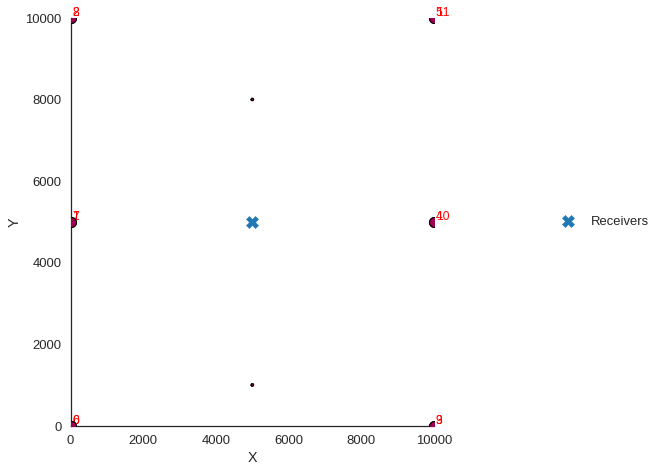

In [3]:

import tensorflow as tf

# gpus = tf.config.experimental.list_physical_devices('GPU') 
# for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)
from sys import getsizeof

import matplotlib
# from ipywidgets import interact, interactive
import os
import numpy as np
import sys
import timeit
import csv
from functools import reduce
import operator

sys.path.append('/content/drive/My Drive/YJ/GP_old')

sys.path.append('/content/drive/My Drive/YJ')

sys.path.append('/content/drive/MyDrive/YJ/Gravity_valid')
import matplotlib.pyplot as plt

from gempy.core.grid_modules.grid_types import CenteredGrid

import gempy as gp
from gempy.core.tensor.tensorflow_graph_test import TFGraph
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
from gempy import create_data, map_series_to_surfaces
from gempy.assets.geophysics import GravityPreprocessing
tfd = tfp.distributions
import seaborn as sns
import copy
from gempy.plot.visualization_2d_pro import *
from ThreeLayer import *
# %%

X = [5000]
Y = [5000]
# X = np.linspace(2000,8000,5)
# Y = np.linspace(3000,7000,4)

r = []
for x in X:
  for y in Y:
    r.append(np.array([x,y]))
receivers = np.array(r)
Z = 1000
n_devices = receivers.shape[0]

path = '/content/drive/MyDrive/YJ/GP_old/notebooks'
orientation_path = "/data/input_data/George_models/modely_orientations.csv"
surface_path = '/data/input_data/George_models/'+"modely"+'_surface_points.csv'

center_grid_resolution = [30, 30, 40]
regular_grid_resolution =[100, 100, 30]

model = ModelThree(path,surface_path,orientation_path,receivers = receivers,center_grid_resolution = center_grid_resolution,regular_grid_resolution =regular_grid_resolution,dtype = 'float64')
model.plot_model()
plt.show()

In [4]:
tf.__version__

'2.6.0'

In [ ]:
def make_variables(k, initializer):
  return (tf.Variable(initializer(shape=[k], dtype=tf.float32)))


def softmax_space(parameters):
  return tf.nn.softmax(parameters)


def constant32(x):
  return tf.constant(x,dtype=tf.float32)

In [ ]:
resolution = constant32([20,20,10])
radius =constant32([3000,3000,1000])
size = (resolution[0]+1)*(resolution[1]+1)*(resolution[2])


In [ ]:
def target_tz(radius,resolution):
  if not isinstance(radius, list) or isinstance(radius, np.ndarray):
    radius = np.repeat(radius, 3)
  g_ = []
  g_2 = [] # contains exp coord, left right xy, top and bottom
  d_ = []
  for xyz in [0, 1, 2]:

      if xyz == 2:
          # Make the grid only negative for the z axis

          g_ = np.geomspace(0.01, 1, int(resolution[xyz]))
          g_2.append(
              (np.concatenate(([0], g_)) + 0.005) * - radius[xyz])
      else:
          g_=(np.geomspace(0.01, 1, int(resolution[xyz] / 2)+1))
          g_2.append(
              np.concatenate((-g_[::-1], g_)) * radius[xyz])
  #my modification below, change the left/right boundary to grow exponentally instead of the center point

  x_center = (g_2[0][:-1]+g_2[0][1:])/2 
  y_center = (g_2[1][:-1]+g_2[1][1:])/2
  z_center = (g_2[-1][:-1]+g_2[-1][1:])/2
  g = np.meshgrid(x_center,y_center,z_center)

  d_left_x = np.abs(g_2[0][:-1] - x_center)
  d_left_y = np.abs(g_2[1][:-1] - y_center)
  d_right_x = np.abs(g_2[0][1:] - x_center)
  d_right_y = np.abs(g_2[1][1:] - y_center)
  d_z = z_center - g_2[-1][:-1]

  d_left = np.meshgrid(d_left_x,d_left_y,d_z)
  d_right = np.meshgrid(d_right_x,d_right_y,d_z)

  kernel_g = np.vstack(tuple(map(np.ravel, g))).T.astype("float64")
  kernel_d_left = np.vstack(tuple(map(np.ravel, d_left))).T.astype("float64")
  kernel_d_right = np.vstack(tuple(map(np.ravel, d_right))).T.astype("float64")

  grid_values = kernel_g

  s_gr_x = grid_values[:, 0]
  s_gr_y = grid_values[:, 1]
  s_gr_z = grid_values[:, 2]

  # getting the coordinates of the corners of the voxel...
  x_cor = np.stack((s_gr_x - kernel_d_left[:, 0], s_gr_x + kernel_d_right[:, 0]), axis=1)
  y_cor = np.stack((s_gr_y - kernel_d_left[:, 1], s_gr_y + kernel_d_right[:, 1]), axis=1)
  z_cor = np.stack((s_gr_z - kernel_d_left[:, 2], s_gr_z + kernel_d_right[:, 2]), axis=1)

  # compute the target tz for the whole grid
  UNI_grid_x = np.array([[np.min(x_cor),np.max(x_cor)]])
  UNI_grid_y = np.array([[np.min(y_cor),np.max(y_cor)]])
  UNI_grid_z = np.array([[np.max(z_cor),np.min(z_cor)]])

  xUNI_matrix = np.repeat(UNI_grid_x, 4, axis=1)
  yUNI_matrix = np.tile(np.repeat(UNI_grid_y, 2, axis=1), (1, 2))
  zUNI_matrix = np.tile(UNI_grid_z, (1, 4))

  sUNI_r = np.sqrt(xUNI_matrix ** 2 + yUNI_matrix ** 2 + zUNI_matrix ** 2)
  
  mu = np.array([1, -1, -1, 1, -1, 1, 1, -1])
  G = 6.674e-3

  tz_UNI = (
        G *
        np.sum(- 1 *
                mu * (
                        xUNI_matrix * np.log(yUNI_matrix + sUNI_r) +
                        yUNI_matrix * np.log(xUNI_matrix + sUNI_r) -
                        zUNI_matrix * np.arctan(xUNI_matrix * yUNI_matrix / (zUNI_matrix * sUNI_r))),
                axis=1))
  avg_tz = tz_UNI/kernel_g.shape[0]
  # print(xUNI_matrix,yUNI_matrix,z_cor)
  return avg_tz

In [ ]:
target_tz_matrix = tf.repeat(constant32(target_tz(list(radius.numpy()),resolution)),int(size))

In [ ]:

def compute_tz(a,b,c):
  g_x = tf.cumsum(softmax_space(a))
  g_y = tf.cumsum(softmax_space(b))
  g_z = tf.cumsum(softmax_space(c))

  g2_x = tf.concat((-g_x[::-1], g_x),axis=0) * radius[0]
  g2_y = tf.concat((-g_y[::-1], g_y),axis=0) * radius[1]
  g2_z =  (tf.concat(([0], g_z),axis=0) + 0.005) * - radius[2]

  x_center = (g2_x[:-1]+g2_x[1:])/2 
  y_center = (g2_y[:-1]+g2_y[1:])/2
  z_center = (g2_z[:-1]+g2_z[1:])/2

  g = tf.meshgrid(x_center,y_center,z_center)

  d_left_x = tf.math.abs(g2_x[:-1] - x_center)
  d_left_y = tf.math.abs(g2_y[:-1] - y_center)
  d_right_x = tf.math.abs(g2_x[1:] - x_center)
  d_right_y = tf.math.abs(g2_y[1:] - y_center)
  d_z = z_center - g2_z[:-1]

  d_left = tf.meshgrid(d_left_x,d_left_y,d_z)
  d_right = tf.meshgrid(d_right_x,d_right_y,d_z)

  kernel_g = tf.concat([tf.reshape(g[0],[-1,1]),tf.reshape(g[1],[-1,1]),tf.reshape(g[2],[-1,1])],axis=1)
  kernel_d_left = tf.concat([tf.reshape(d_left[0],[-1,1]),tf.reshape(d_left[1],[-1,1]),tf.reshape(d_left[2],[-1,1])],axis=1)
  kernel_d_right = tf.concat([tf.reshape(d_right[0],[-1,1]),tf.reshape(d_right[1],[-1,1]),tf.reshape(d_right[2],[-1,1])],axis=1)

  s_gr_x = kernel_g[:, 0]
  s_gr_y = kernel_g[:, 1]
  s_gr_z = kernel_g[:, 2]

  # # getting the coordinates of the corners of the voxel...
  x_cor = tf.transpose(tf.stack([s_gr_x - kernel_d_left[:, 0], s_gr_x + kernel_d_right[:, 0]], axis=0))
  y_cor = tf.transpose(tf.stack((s_gr_y - kernel_d_left[:, 1], s_gr_y + kernel_d_right[:, 1]), axis=0))
  z_cor = tf.transpose(tf.stack((s_gr_z - kernel_d_left[:, 2], s_gr_z + kernel_d_right[:, 2]), axis=0))

  x_matrix = tf.repeat(x_cor, 4, axis=1)
  y_matrix = tf.tile(tf.repeat(y_cor, 2, axis=1), (1, 2))
  z_matrix = tf.tile(z_cor, (1, 4))

  s_r = tf.sqrt(x_matrix ** 2 + y_matrix ** 2 + z_matrix ** 2)

  mu = constant32([1, -1, -1, 1, -1, 1, 1, -1])

  G = constant32(6.674e-3)

  tz = (
        G *
        tf.reduce_sum(- 1 *
                mu * (
                        x_matrix * tf.math.log(y_matrix + s_r) +
                        y_matrix * tf.math.log(x_matrix + s_r) -
                        z_matrix * tf.math.atan(x_matrix * y_matrix / (z_matrix * s_r))),
                axis=1))
  return tz

def loss(a,b,c,target_tz_matrix):
  tz = compute_tz(a,b,c)
  l = (tf.square(tz-target_tz_matrix))
  return tf.reduce_mean(l)


# def loss(a,b,c):
#   tz = compute_tz(a,b,c)
#   l = tf.math.reduce_std(tz)
#   return l


In [ ]:
min = -1
max = 1
a = make_variables(tf.cast(resolution[0]/2+1,tf.int32),initializer= tf.random_uniform_initializer(minval=min, maxval=max, seed=None))
b = make_variables(tf.cast(resolution[1]/2+1,tf.int32),initializer= tf.random_uniform_initializer(minval=min, maxval=max, seed=None))
c = make_variables(tf.cast(resolution[2],tf.int32),initializer= tf.random_uniform_initializer(minval=min, maxval=max, seed=None))

# def tflog10(x):
#   numerator = tf.math.log(x)
#   denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
#   return numerator / denominator
# def inv_softmax(x, C):
#    return tf.math.log(x) + C

# a = tf.pow(10.,tf.linspace(tflog10(0.01),tflog10(1.),int(resolution[0]/2+1))).numpy()
# aa = a.copy()
# aa[1:]=np.diff(a)
# b = tf.pow(10.,tf.linspace(tflog10(0.01),tflog10(1.),int(resolution[1]/2+1))).numpy()
# bb = a.copy()
# bb[1:]=np.diff(b)
# c = tf.pow(10.,tf.linspace(tflog10(0.01),tflog10(1.),int(resolution[2]))).numpy()
# cc = c.copy()
# cc[1:]=np.diff(c)

# a = tf.Variable(inv_softmax(aa,1))
# b = tf.Variable(inv_softmax(bb,1))
# c = tf.Variable(inv_softmax(cc,1))



var_list =[a,b,c]

@tf.function
def train_step(a,b,c):
  with tf.GradientTape() as tape:
    loss_value = loss(a,b,c,target_tz_matrix)
    grads = tape.gradient(loss_value,var_list)

  opt.apply_gradients(zip(grads, var_list))
  return loss_value

In [ ]:
# opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
opt = tf.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

import time
epochs = 20000
for epoch in range(epochs):
  
  
  start_time = time.time()
  loss_value = train_step(a,b,c)
  if epoch%200==0:
    print("\nStart of epoch %d" % (epoch,))
    print("loss: %.10f" % (float(loss_value),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
loss: 0.0040778229
Time taken: 1.86s

Start of epoch 200
loss: 0.0003086073
Time taken: 0.00s

Start of epoch 400
loss: 0.0001662287
Time taken: 0.00s

Start of epoch 600
loss: 0.0001183400
Time taken: 0.00s

Start of epoch 800
loss: 0.0000816948
Time taken: 0.00s

Start of epoch 1000
loss: 0.0000713582
Time taken: 0.00s

Start of epoch 1200
loss: 0.0000695396
Time taken: 0.00s

Start of epoch 1400
loss: 0.0000685310
Time taken: 0.00s

Start of epoch 1600
loss: 0.0000678620
Time taken: 0.00s

Start of epoch 1800
loss: 0.0000674228
Time taken: 0.00s

Start of epoch 2000
loss: 0.0000671449
Time taken: 0.00s

Start of epoch 2200
loss: 0.0000669798
Time taken: 0.00s

Start of epoch 2400
loss: 0.0000668906
Time taken: 0.00s

Start of epoch 2600
loss: 0.0000668467
Time taken: 0.00s

Start of epoch 2800
loss: 0.0000668283
Time taken: 0.00s

Start of epoch 3000
loss: 0.0000668207
Time taken: 0.00s

Start of epoch 3200
loss: 0.0000668182
Time taken: 0.00s

Start of epoch 3400


In [ ]:
a,b,c = var_list

In [ ]:
loss(a,b,c,target_tz_matrix)

<tf.Tensor: shape=(), dtype=float32, numpy=6.681625e-05>

In [ ]:
g_x = softmax_space(a)
tf.cumsum(g_x)

<tf.Tensor: shape=(11,), dtype=float32, numpy=
array([0.00188065, 0.00876294, 0.02135833, 0.0401372 , 0.06643016,
       0.10236328, 0.15168779, 0.22173128, 0.3288917 , 0.51862156,
       0.9999999 ], dtype=float32)>

In [ ]:
def create_irregular_grid_kernel(resolution, radius,a,b,c):

    g_x = tf.cumsum(softmax_space(a))
    g_y = tf.cumsum(softmax_space(b))
    g_z = tf.cumsum(softmax_space(c))

    g2_x = tf.concat((-g_x[::-1], g_x),axis=0) * radius[0]
    g2_y = tf.concat((-g_y[::-1], g_y),axis=0) * radius[1]
    g2_z =  (tf.concat(([0], g_z),axis=0) + 0.005) * - radius[2]

    x_center = (g2_x[:-1]+g2_x[1:])/2 
    y_center = (g2_y[:-1]+g2_y[1:])/2
    z_center = (g2_z[:-1]+g2_z[1:])/2

    g = tf.meshgrid(x_center,y_center,z_center)

    d_left_x = tf.math.abs(g2_x[:-1] - x_center)
    d_left_y = tf.math.abs(g2_y[:-1] - y_center)
    d_right_x = tf.math.abs(g2_x[1:] - x_center)
    d_right_y = tf.math.abs(g2_y[1:] - y_center)
    d_z = z_center - g2_z[:-1]

    d_left = tf.meshgrid(d_left_x,d_left_y,d_z)
    d_right = tf.meshgrid(d_right_x,d_right_y,d_z)

    kernel_g = tf.concat([tf.reshape(g[0],[-1,1]),tf.reshape(g[1],[-1,1]),tf.reshape(g[2],[-1,1])],axis=1)
    kernel_d_left = tf.concat([tf.reshape(d_left[0],[-1,1]),tf.reshape(d_left[1],[-1,1]),tf.reshape(d_left[2],[-1,1])],axis=1)
    kernel_d_right = tf.concat([tf.reshape(d_right[0],[-1,1]),tf.reshape(d_right[1],[-1,1]),tf.reshape(d_right[2],[-1,1])],axis=1)

    return kernel_g, kernel_d_left, kernel_d_right


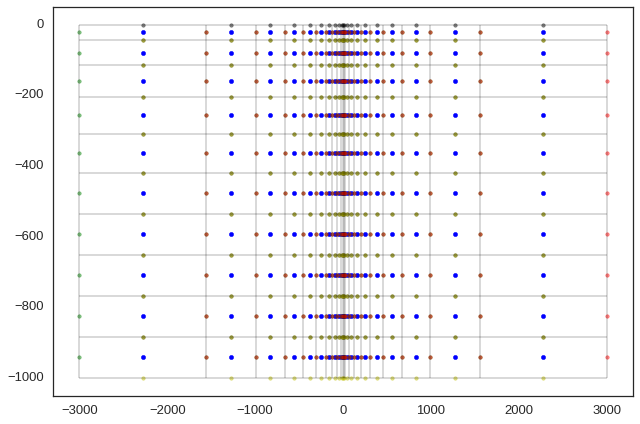

In [ ]:
def plot_kernel(res,radius,a,b,c,direction = 'y',n_section = 5):
  res_ =copy.deepcopy(res.numpy()).astype(int)
  if direction == 'y': i = 0 
  else: i = 1
  
  kernel_g, kernel_d_left, kernel_d_right =create_irregular_grid_kernel(resolution,radius,a,b,c)
  kernel_g, kernel_d_left, kernel_d_right = kernel_g.numpy(), kernel_d_left.numpy(), kernel_d_right.numpy()

  Slice = n_section
  # Trick just for plotting
  # the resolution is transposed in meshgrid
  if res_[0]%2 == 0:
    res_[0]+=1
  if res_[1]%2 == 0:
    res_[1]+=1
  # res_[2]+=1
  res_[0],res_[1] =res_[1], res_[0]
  # plotting the centers
  if i == 0: # y direction    
    center_xy_coord = kernel_g[:,i].reshape(res_)[Slice,:,:]
    center_z_coord = kernel_g[:,2].reshape(res_)[Slice,:,:]
    # plt.scatter(kernel_g[:,i].reshape(res_)[Slice,:,:],kernel_g[:,2].reshape(res_)[Slice,:,:],c = 'b') # center
    # plt.scatter((kernel_g[:,i]-kernel_d_left[:,i]).reshape(res_)[Slice,:,:],kernel_g[:,2].reshape(res_)[Slice,:,:],'r')
  if i == 1: # x direction
    center_xy_coord = kernel_g[:,i].reshape(res_)[:,Slice,:]
    center_z_coord = kernel_g[:,2].reshape(res_)[:,Slice,:]

  plt.scatter(center_xy_coord,center_z_coord,s  =19,c = 'b') # center
  left_x = (kernel_g[:,i]-kernel_d_left[:,i]).reshape(res_)[:,Slice,:].flatten()
  right_x = (kernel_g[:,i]+kernel_d_right[:,i]).reshape(res_)[:,Slice,:].flatten()
  top_z = (kernel_g[:,2]-kernel_d_left[:,2]).reshape(res_)[:,Slice,:].flatten()
  bot_z = (kernel_g[:,2]+kernel_d_left[:,2]).reshape(res_)[:,Slice,:].flatten()

  plt.scatter(left_x,center_z_coord.flatten(),s  =13, c = 'g',alpha=0.5) # left
  plt.scatter(right_x,center_z_coord.flatten(),s = 13, c = 'r',alpha=0.5) # right
  plt.scatter(center_xy_coord,top_z,s = 13, c = 'k',alpha=0.5) # top
  plt.scatter(center_xy_coord,bot_z,s = 13, c = 'y',alpha=0.5) # bot
  
  plt.vlines(x = left_x[::res_[-1]],ymax = np.min(bot_z),ymin = np.max(top_z),linewidth=0.3,alpha=1,colors='black')
  plt.vlines(x = right_x[-1],ymax = np.min(bot_z),ymin = np.max(top_z),linewidth=0.3,alpha=1,colors='black')

  plt.hlines(y = bot_z[:res_[-1]],xmax = np.min(left_x),xmin = np.max(right_x),linewidth=0.3,alpha=1,colors='black')
  plt.hlines(y = top_z[0],xmax = np.min(left_x),xmin = np.max(right_x),linewidth=0.3,alpha=1,colors='black')
plot_kernel(resolution,[3000,3000,1000],a,b,c,direction='x',n_section = 2)

In [ ]:
tz = compute_tz(a,b,c)

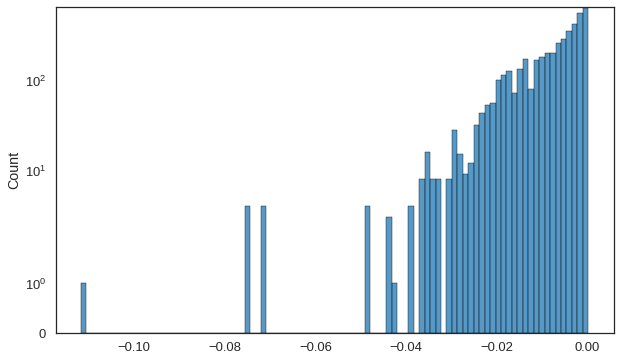

In [ ]:
import math
fig, ax = plt.subplots(figsize=(10,6))
w = 0.005
n = math.ceil((tz.numpy().max() - tz.numpy().min())/w)
# sns.histplot(data=tz, bins = n)
sns.histplot(data=tz)
ax.set_yscale('symlog')

In [ ]:
print('machine learning grid', 'std:',np.std(tz),'mean',np.mean(tz),'sum',np.sum(tz))

machine learning grid std: 0.00817412 mean -0.008099914 sum -35.72062


In [ ]:
np.min(tz)

-0.11172635

In [ ]:
tz.shape

TensorShape([4410])